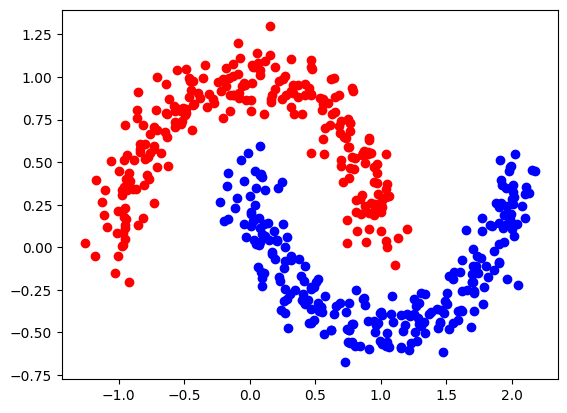

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import numpy as np
import torch

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

n_sample = 500
X, y = make_moons(n_samples=n_sample, noise=0.1)
color = ['red', 'blue']

for i in range(n_sample):
    plt.scatter(X[i,0],X[i,1],color=color[y[i]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons


phase = "toy_swap"

plot_log = 50#50

steps = 10001

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

# create dataset

d_in = 2
d_out = 2

n_sample = 200
X, y = make_moons(n_samples=n_sample, noise=0.1)
X = torch.tensor(X, dtype=torch.float, requires_grad=True)
y = torch.tensor(y, dtype=torch.long)

n_sample = 200
X_test, y_test = make_moons(n_samples=n_sample, noise=0.1)
X_test = torch.tensor(X_test, dtype=torch.float, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.long)


width = 20
depth = 3
shp = [d_in, 20, 20, d_out]


seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float)
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float)
        self.input = None
        self.output = None
        
    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output


class BioMLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))
                
            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.2 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        #self.register_parameter(name='in_perm', param=torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float)))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        #self.register_parameter(name='out_perm', param=torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float)))
        self.top_k = 10
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped. 
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)
            
    def plot(self):
        #fig, ax = plt.subplots(figsize=(6,6))
        ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                    
        ax.axis('off')
        
        
    def thresholding(self, threshold, checkpoint = True):
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num
                
    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value
                
    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)
                

# model = BioMLP(shp=[2,20,20,2])

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
# #steps = 10000
# log = 200
# lamb = 0.001
# swap_log = 200



# for step in range(steps):
    
#     # small lambda first, then large lambda, then small lambda
#     if step == 5000:
#         lamb = 0.01
        
#     if step == 15000:
#         lamb = 0.001
    
#     CEL = nn.CrossEntropyLoss()
    
#     optimizer.zero_grad()
#     pred  = model(X)
#     loss = CEL(pred, y)
#     #print((torch.argmax(pred, dim=1) == y).float())
#     acc = torch.mean((torch.argmax(pred, dim=1) == y).float())
    
    
#     pred_test  = model(X_test)
#     loss_test = CEL(pred_test, y_test)
#     acc_test = torch.mean((torch.argmax(pred_test, dim=1) == y_test).float())
    
#     reg = model.get_cc(weight_factor=1.)
#     total_loss = loss + lamb*reg
#     total_loss.backward()
#     optimizer.step()
    
#     if step % log == 0:
#         print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | train acc : %.2f | test acc : %.2f | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), acc.detach().numpy(), acc_test.detach().numpy(), reg.detach().numpy()))
    
#     if (step+1) % swap_log == 0:
#         #pass
#         model.relocate()


#     if step % plot_log == 0:
#         plt.figure(figsize=(3, 7)) 

#         plt.subplot(2,1,1)

#         N = 2
#         s = 1/(2*max(shp))
#         for j in range(len(shp)):
#             N = shp[j]
#             for i in range(N):
#                 circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
#                 plt.gca().add_patch(circle)


#         plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
#         plt.xlim(-0.02,1.02)

#         ii = 0
#         for p in model.parameters():


#             if len(p.shape) == 2:
#                 p_shp = p.shape
#                 p = p/torch.abs(p).max()
#                 for i in range(p_shp[0]):
#                     for j in range(p_shp[1]):
#                         if p[i,j] > 0:
#                             plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*p_shp[1])+j/p_shp[1]], [0.1*(ii+1),0.1*ii], lw=1*np.abs(p[i,j].detach().numpy()), color="blue")
#                         else:
#                             plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*p_shp[1])+j/p_shp[1]], [0.1*(ii+1),0.1*ii], lw=1*np.abs(p[i,j].detach().numpy()), color="red")

#                 formulas = ["Class 1", "Class 2"]
#                 if ii == 0:
#                     for j in range(p_shp[1]):
#                         plt.text(1/(2*p_shp[1])+j/p_shp[1]-0.05, 0.1*ii-0.04, "$x_{}$".format(model.in_perm[j].long()+1), fontsize=15)
#                 ii += 1


#         for j in range(p_shp[0]):
#             plt.text(1/(2*p_shp[0])+j/p_shp[0]-0.15, 0.1*ii+0.02, formulas[model.out_perm[j].long()], fontsize=15)

#         plt.gca().axis('off')
#         plt.title("step={}".format(step), fontsize=15, y=1.1)


#         plt.subplot(2,1,2)


#         start_x = X[:,0].min()-0.1
#         end_x = X[:,0].max()+0.1
#         start_y = X[:,1].min()-0.1
#         end_y = X[:,1].max()+0.1
#         n_values = 30

#         x_vals = np.linspace(start_x.detach().numpy(), end_x.detach().numpy(), n_values)
#         y_vals = np.linspace(start_y.detach().numpy(), end_y.detach().numpy(), n_values)
#         XX, YY = np.meshgrid(x_vals, y_vals)
#         pred = model(torch.tensor([XX.reshape(-1,), YY.reshape(-1,)], dtype=torch.float).permute(1,0))
#         pred = pred[:,1] - pred[:,0]

#         #ZZ = np.sqrt(XX**2 + YY**2)

#         cp = plt.contourf(XX, YY, pred.reshape(n_values,n_values).detach().numpy(), [-100,0.,100.], colors=["green","orange"], alpha=0.2)
#         #plt.colorbar(cp)
#         color = ['green', 'orange']

#         for i in range(n_sample):
#             plt.scatter(X[i,0].detach().numpy(),X[i,1].detach().numpy(),color=color[y[i]])


#         plt.xticks([])
#         plt.yticks([])
#         plt.xlabel(r"$x_1$", fontsize=15)
#         plt.ylabel(r"$x_2$", fontsize=15)
#         #plt.show()
    
#         #plt.savefig("./results/two_moon/steps/{0:05d}.png".format(step))
        
#         plt.show()
    

In [4]:
torch.save(model.state_dict(), 'two_moons_mod.pt')

In [ ]:

model2 = BioMLP(shp=[2,20,20,2])

optimizer = torch.optim.AdamW(model2.parameters(), lr=0.002, weight_decay=0.0)
#steps = 10000
log = 200
# lamb = 0.001
# swap_log = 200

# train_type = 1; no L1
train_type = 2; #L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
lamb = 0 if train_type==1 else 0.01
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.

for step in range(steps):
    
    # small lambda first, then large lambda, then small lambda
    if step == 5000:
        lamb = 0.01
        
    if step == 15000:
        lamb = 0.001
    
    CEL = nn.CrossEntropyLoss()
    
    optimizer.zero_grad()
    pred  = model2(X)
    loss = CEL(pred, y)
    #print((torch.argmax(pred, dim=1) == y).float())
    acc = torch.mean((torch.argmax(pred, dim=1) == y).float())
    
    
    pred_test  = model2(X_test)
    loss_test = CEL(pred_test, y_test)
    acc_test = torch.mean((torch.argmax(pred_test, dim=1) == y_test).float())
    
    reg = model2.get_cc(weight_factor)
    total_loss = loss + lamb*reg
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | train acc : %.2f | test acc : %.2f | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), acc.detach().numpy(), acc_test.detach().numpy(), reg.detach().numpy()))
    
    if (step+1) % swap_log == 0:
        #pass
        model2.relocate()


    if step % plot_log == 0:
        plt.figure(figsize=(3, 7)) 

        plt.subplot(2,1,1)

        N = 2
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            for i in range(N):
                circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                plt.gca().add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        ii = 0
        for p in model2.parameters():


            if len(p.shape) == 2:
                p_shp = p.shape
                p = p/torch.abs(p).max()
                for i in range(p_shp[0]):
                    for j in range(p_shp[1]):
                        if p[i,j] > 0:
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*p_shp[1])+j/p_shp[1]], [0.1*(ii+1),0.1*ii], lw=1*np.abs(p[i,j].detach().numpy()), color="blue")
                        else:
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*p_shp[1])+j/p_shp[1]], [0.1*(ii+1),0.1*ii], lw=1*np.abs(p[i,j].detach().numpy()), color="red")

                formulas = ["Class 1", "Class 2"]
                if ii == 0:
                    for j in range(p_shp[1]):
                        plt.text(1/(2*p_shp[1])+j/p_shp[1]-0.05, 0.1*ii-0.04, "$x_{}$".format(model2.in_perm[j].long()+1), fontsize=15)
                ii += 1


        for j in range(p_shp[0]):
            plt.text(1/(2*p_shp[0])+j/p_shp[0]-0.15, 0.1*ii+0.02, formulas[model2.out_perm[j].long()], fontsize=15)

        plt.gca().axis('off')
        plt.title("step={}".format(step), fontsize=15, y=1.1)


        plt.subplot(2,1,2)


        start_x = X[:,0].min()-0.1
        end_x = X[:,0].max()+0.1
        start_y = X[:,1].min()-0.1
        end_y = X[:,1].max()+0.1
        n_values = 30

        x_vals = np.linspace(start_x.detach().numpy(), end_x.detach().numpy(), n_values)
        y_vals = np.linspace(start_y.detach().numpy(), end_y.detach().numpy(), n_values)
        XX, YY = np.meshgrid(x_vals, y_vals)
        pred = model2(torch.tensor([XX.reshape(-1,), YY.reshape(-1,)], dtype=torch.float).permute(1,0))
        pred = pred[:,1] - pred[:,0]

        #ZZ = np.sqrt(XX**2 + YY**2)

        cp = plt.contourf(XX, YY, pred.reshape(n_values,n_values).detach().numpy(), [-100,0.,100.], colors=["green","orange"], alpha=0.2)
        #plt.colorbar(cp)
        color = ['green', 'orange']

        for i in range(n_sample):
            plt.scatter(X[i,0].detach().numpy(),X[i,1].detach().numpy(),color=color[y[i]])


        plt.xticks([])
        plt.yticks([])
        plt.xlabel(r"$x_1$", fontsize=15)
        plt.ylabel(r"$x_2$", fontsize=15)
        #plt.show()
    
        #plt.savefig("./results/two_moon/steps/{0:05d}.png".format(step))
        
        plt.show()
    

In [7]:
torch.save(model2.state_dict(), 'two_moons_l1_only.pt')

In [ ]:
model3 = BioMLP(shp=[2,20,20,2])

optimizer = torch.optim.AdamW(model3.parameters(), lr=0.002, weight_decay=0.0)
#steps = 10000
log = 200
# lamb = 0.001
# swap_log = 200

train_type = 1; #no L1
# train_type = 2; #L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
lamb = 0 if train_type==1 else 0.01
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.

for step in range(steps):
    
    # small lambda first, then large lambda, then small lambda
    if step == 5000:
        lamb = 0.01
        
    if step == 15000:
        lamb = 0.001
    
    CEL = nn.CrossEntropyLoss()
    
    optimizer.zero_grad()
    pred  = model3(X)
    loss = CEL(pred, y)
    #print((torch.argmax(pred, dim=1) == y).float())
    acc = torch.mean((torch.argmax(pred, dim=1) == y).float())
    
    
    pred_test  = model3(X_test)
    loss_test = CEL(pred_test, y_test)
    acc_test = torch.mean((torch.argmax(pred_test, dim=1) == y_test).float())
    
    reg = model3.get_cc(weight_factor)
    total_loss = loss + lamb*reg
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | train acc : %.2f | test acc : %.2f | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), acc.detach().numpy(), acc_test.detach().numpy(), reg.detach().numpy()))
    
    if (step+1) % swap_log == 0:
        #pass
        model3.relocate()


    if step % plot_log == 0:
        plt.figure(figsize=(3, 7)) 

        plt.subplot(2,1,1)

        N = 2
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            for i in range(N):
                circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                plt.gca().add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        ii = 0
        for p in model3.parameters():


            if len(p.shape) == 2:
                p_shp = p.shape
                p = p/torch.abs(p).max()
                for i in range(p_shp[0]):
                    for j in range(p_shp[1]):
                        if p[i,j] > 0:
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*p_shp[1])+j/p_shp[1]], [0.1*(ii+1),0.1*ii], lw=1*np.abs(p[i,j].detach().numpy()), color="blue")
                        else:
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*p_shp[1])+j/p_shp[1]], [0.1*(ii+1),0.1*ii], lw=1*np.abs(p[i,j].detach().numpy()), color="red")

                formulas = ["Class 1", "Class 2"]
                if ii == 0:
                    for j in range(p_shp[1]):
                        plt.text(1/(2*p_shp[1])+j/p_shp[1]-0.05, 0.1*ii-0.04, "$x_{}$".format(model3.in_perm[j].long()+1), fontsize=15)
                ii += 1


        for j in range(p_shp[0]):
            plt.text(1/(2*p_shp[0])+j/p_shp[0]-0.15, 0.1*ii+0.02, formulas[model3.out_perm[j].long()], fontsize=15)

        plt.gca().axis('off')
        plt.title("step={}".format(step), fontsize=15, y=1.1)


        plt.subplot(2,1,2)


        start_x = X[:,0].min()-0.1
        end_x = X[:,0].max()+0.1
        start_y = X[:,1].min()-0.1
        end_y = X[:,1].max()+0.1
        n_values = 30

        x_vals = np.linspace(start_x.detach().numpy(), end_x.detach().numpy(), n_values)
        y_vals = np.linspace(start_y.detach().numpy(), end_y.detach().numpy(), n_values)
        XX, YY = np.meshgrid(x_vals, y_vals)
        pred = model3(torch.tensor([XX.reshape(-1,), YY.reshape(-1,)], dtype=torch.float).permute(1,0))
        pred = pred[:,1] - pred[:,0]

        #ZZ = np.sqrt(XX**2 + YY**2)

        cp = plt.contourf(XX, YY, pred.reshape(n_values,n_values).detach().numpy(), [-100,0.,100.], colors=["green","orange"], alpha=0.2)
        #plt.colorbar(cp)
        color = ['green', 'orange']

        for i in range(n_sample):
            plt.scatter(X[i,0].detach().numpy(),X[i,1].detach().numpy(),color=color[y[i]])


        plt.xticks([])
        plt.yticks([])
        plt.xlabel(r"$x_1$", fontsize=15)
        plt.ylabel(r"$x_2$", fontsize=15)
        #plt.show()
    
        #plt.savefig("./results/two_moon/steps/{0:05d}.png".format(step))
        
        plt.show()
    

In [9]:
torch.save(model3.state_dict(), 'two_moons_no_l1.pt')

# Loading models

In [25]:
model3 = BioMLP(shp=[2,20,20,2])
model3.load_state_dict(torch.load('two_moons_no_l1.pt'))

<All keys matched successfully>

In [26]:
model2 = BioMLP(shp=[2,20,20,2])
model2.load_state_dict(torch.load('two_moons_l1_only.pt'))

<All keys matched successfully>

In [38]:
model = BioMLP(shp=[2,20,20,2])
model.load_state_dict(torch.load('two_moons_mod.pt'))

<All keys matched successfully>

# Superposition plots 

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [18]:
# [2,20,20,2]
for p in model2.parameters():
    if p.shape==torch.Size([20, 20]):
        W = p

norms = torch.linalg.norm(W.T, 2, dim=-1).cpu()
norms


tensor([1.1770e-03, 8.8259e-04, 2.4260e+00, 7.1206e-04, 2.0185e+00, 8.6213e-04,
        1.0223e-03, 9.4071e-04, 9.5435e-04, 1.8746e+00, 1.1803e-03, 1.2054e-03,
        1.2658e-03, 1.5346e-03, 9.8777e-04, 1.0992e-03, 1.2047e-03, 1.0436e-03,
        1.1518e-03, 2.5920e+00], grad_fn=<LinalgVectorNormBackward0>)

In [24]:
W[:, 0]

tensor([ 4.0630e-04,  6.0036e-05,  2.1280e-04, -2.8162e-04,  1.0796e-04,
        -2.1533e-04, -2.3395e-04,  4.8946e-05,  1.7694e-04,  2.6536e-04,
         1.4069e-04, -8.7712e-05, -5.7932e-04, -8.6428e-05, -3.3519e-04,
         2.8937e-04,  3.5111e-04, -1.9856e-04,  2.6495e-04, -2.7486e-04],
       grad_fn=<SelectBackward0>)

In [19]:
torch.linalg.norm(W, 2, dim=-1)

tensor([3.4730e+00, 1.1337e-03, 1.3478e-03, 8.3370e-04, 9.8301e-04, 9.2354e-04,
        1.1825e-03, 9.5054e-04, 8.9494e-04, 9.8978e-04, 1.3386e+00, 1.1205e-03,
        9.6920e-04, 1.2306e-03, 1.0659e-03, 1.0062e-03, 1.3353e-03, 1.0573e-03,
        1.1721e-03, 2.5177e+00], grad_fn=<LinalgVectorNormBackward0>)

In [20]:
torch.linalg.norm(W.T, 2, dim=-1)

tensor([1.1770e-03, 8.8259e-04, 2.4260e+00, 7.1206e-04, 2.0185e+00, 8.6213e-04,
        1.0223e-03, 9.4071e-04, 9.5435e-04, 1.8746e+00, 1.1803e-03, 1.2054e-03,
        1.2658e-03, 1.5346e-03, 9.8777e-04, 1.0992e-03, 1.2047e-03, 1.0436e-03,
        1.1518e-03, 2.5920e+00], grad_fn=<LinalgVectorNormBackward0>)

In [15]:


# for p in model2.parameters():
#     print(p.shape)
W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, W)
interference[torch.arange(20), torch.arange(20)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(W, 2, dim=-1).cpu()

WtW = torch.einsum('ih,oh->io', W, W).cpu()
print(polysemanticity.shape)
print(norms)

x = torch.arange(20)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

# fig = make_subplots(rows=len([1]),
#                       cols=2,
#                       shared_xaxes=True,
#                       vertical_spacing=0.02,
#                       horizontal_spacing=0.1)
# fig.add_trace(
#         go.Bar(x=x.detach().numpy(), 
#               y=norms.detach().numpy(),
#               marker=dict(
#                   color=polysemanticity.detach().numpy(),
#                   cmin=0,
#                   cmax=1
#               ),
#               width=width,
#         ),
#         row=1, col=1
#     )
# data = WtW.detach().numpy()
# fig = go.Figure(go.Image(
#             z=plt.cm.coolwarm((1 + data)/2, bytes=True),
#             colormodel='rgba256',
#             customdata=data,
#             hovertemplate='''\
# In: %{x}<br>
# Out: %{y}<br>
# Weight: %{customdata:0.2f}
# '''            
#     ))
# fig.show()
# fig.add_trace(
#         go.Image(
#             z=plt.cm.coolwarm((1 + data)/2, bytes=True),
#             colormodel='rgba256',
#             customdata=data,
#             hovertemplate='''\
# In: %{x}<br>
# Out: %{y}<br>
# Weight: %{customdata:0.2f}
# '''            
#     ),
#     # row=1+row, col=2
# )

# fig.add_vline(
# x=(x[20-1]+x[20-1])/2, 
# line=dict(width=0.5),
# col=1,
# )

# # fig.update_traces(marker_size=1)
# fig.update_layout(showlegend=False, 
#                 width=600,
#                 height=100,
#                 margin=dict(t=0, b=0))
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)

# # fig.update_layout()


torch.Size([20])
tensor([3.4730e+00, 1.1337e-03, 1.3478e-03, 8.3370e-04, 9.8301e-04, 9.2354e-04,
        1.1825e-03, 9.5054e-04, 8.9494e-04, 9.8978e-04, 1.3386e+00, 1.1205e-03,
        9.6920e-04, 1.2306e-03, 1.0659e-03, 1.0062e-03, 1.3353e-03, 1.0573e-03,
        1.1721e-03, 2.5177e+00], grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
def render_features(model):
#   cfg = model.config
  W = model.W.detach()
  W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
  net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
  norms = torch.linalg.norm(W, 2, dim=-1).cpu()

  WtW = torch.einsum('sih,soh->sio', W, W).cpu()

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features)
  width = 0.9

  which_instances = np.arange(cfg.n_instances)[which]
  fig = make_subplots(rows=len(which_instances),
                      cols=2,
                      shared_xaxes=True,
                      vertical_spacing=0.02,
                      horizontal_spacing=0.1)
  for (row, inst) in enumerate(which_instances):
    fig.add_trace(
        go.Bar(x=x, 
              y=norms[inst],
              marker=dict(
                  color=polysemanticity[inst],
                  cmin=0,
                  cmax=1
              ),
              width=width,
        ),
        row=1+row, col=1
    )
    data = WtW[inst].numpy()
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
'''            
        ),
        row=1+row, col=2
    )

  fig.add_vline(
    x=(x[cfg.n_hidden-1]+x[cfg.n_hidden])/2, 
    line=dict(width=0.5),
    col=1,
  )
    
  # fig.update_traces(marker_size=1)
  fig.update_layout(showlegend=False, 
                    width=600,
                    height=100*len(which_instances),
                    margin=dict(t=0, b=0))
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  return fig

## Superposition v2

In [37]:
i = 2
top_k = 20
linears = model2.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
    print(score)
# print(score)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
print(top_index)
# score = score[top_index]

# num = score.shape[0]

features = model2.linears[1].linear.weight[top_index].T
print(features)

W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, features)
interference[torch.arange(20), torch.arange(20)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()

# WtW = torch.einsum('ih,oh->io', features, features).cpu()
print(polysemanticity.shape)
print(norms)

x = torch.arange(20)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

tensor([1.0416e+01, 5.1231e-03, 5.1034e-03, 3.2222e-03, 3.4181e-03, 3.6577e-03,
        4.5404e-03, 3.6662e-03, 3.8096e-03, 3.8463e-03, 2.6212e+00, 4.4260e-03,
        4.4001e-03, 4.2473e-03, 4.3146e-03, 4.4601e-03, 4.8713e-03, 3.6870e-03,
        4.4020e-03, 6.1400e+00], grad_fn=<AddBackward0>)
tensor([ 0, 19, 10,  1,  2, 16,  6, 15, 11, 18, 12, 14, 13,  9,  8, 17,  7,  5,
         4,  3])
tensor([[ 4.0630e-04, -2.7486e-04,  1.4069e-04,  6.0036e-05,  2.1280e-04,
          3.5111e-04, -2.3395e-04,  2.8937e-04, -8.7712e-05,  2.6495e-04,
         -5.7932e-04, -3.3519e-04, -8.6428e-05,  2.6536e-04,  1.7694e-04,
         -1.9856e-04,  4.8946e-05, -2.1533e-04,  1.0796e-04, -2.8162e-04],
        [ 8.4124e-05,  2.7538e-05, -2.5075e-04, -4.1077e-04, -3.3035e-04,
         -3.7330e-04,  2.5609e-04,  2.6862e-04,  6.4413e-05,  2.1039e-04,
         -1.9415e-04,  3.7538e-05, -2.7836e-05,  1.5666e-04,  1.2260e-05,
          1.8468e-04,  2.9207e-05,  3.3142e-06,  6.8702e-05,  2.4982e-05],
        [-6.

In [43]:
linears = model.get_linear_layers()
W = linears[1].linear.weight.T
print(W.shape)
score = torch.sum(torch.abs(W), dim=0)
# print(score)
top_index = torch.flip(torch.argsort(score),[0])
features = model.linears[1].linear.weight[top_index].T
# print(W.shape)
# print(W)

W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
# print(W_norm.shape)
# print(W_norm)
interference = torch.einsum('fh,gh->fg', W_norm, features)
# print(interference.shape)
interference[torch.arange(20), torch.arange(20)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()

x = torch.arange(20)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

torch.Size([20, 20])
